In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time
from utils import *
import math


In [2]:
class Node(torch.nn.Module):
    def __init__(self, thresh = 1, decay_rate = 0.8, lr = 0.1, name = "Node"):
        super(Node, self).__init__()
        
        self.decay_rate = torch.tensor(decay_rate).float()
        self.lr = lr
        
        self.connections = []
        self.name = name
        
        self.thresh = thresh
        self.lr_decay = 0.95
        
    def add(self, x):
        self.connections.append(x)
        self.weights = torch.zeros(len(self.connections))
        self.charges = torch.zeros(len(self.connections))
        
        self.expected_error = torch.ones(len(self.connections)) #* 0.1
        self.mean =  torch.ones(len(self.connections)) * 0.5
        #self.reset_parameters()
        
    def get_ratios(self):
        ratios = torch.zeros([len(self.connections),2])
        for i in range(len(ratios)):
            #ratios[i] = (self.expected_error/self.connections[i].expected_error)**1/2
            
            b = self.get_uncertainty(self.connections[i])
            s = self.connections[i].get_uncertainty(self)
            ratios[i][0] = b
            ratios[i][1] = s
            #ratios[i] = self.connections[i].expected_error/self.expected_error
        
        return ratios
    
    def correct_weights(self):
        r = self.get_ratios()
        out = torch.zeros([len(self.connections)])
        for i in range(len(self.connections)):
            q = r[i][0]/ r[i][1]
            #calculate correction
            #c = (-self.connections[i].get_weight(self) - (r[i] * self.weights[i]))/ (r[i] + 1)
            c = (-self.connections[i].get_maxl(self) - (q * self.max_l(i)))/ (q + 1)
            
            
            #Calculate normilazing coefficient
            n = torch.max(self.connections[i].get_maxl(self), self.max_l(i)).float()
            #n *= torch.abs()
            #add to other and self weight
            #self.connections[i].add_to_weight(self, c, norm = n)
            out[i] = (self.max_l(i) + c)/n #(torch.abs(r[i][0]- r[i][1])/n)
            
        return out
    
    def get_weight(self, x):
        #for w,c in zip(self.max_l(),self.connections):
        for w,c in zip(self.weights,self.connections):    
            if c is x:
                return w
        raise Exception('Connecting Neuron not found')
    
    def get_maxl(self, x):
        for idx,c in enumerate(self.connections):   
            if c is x:
                return self.max_l(idx)
        raise Exception('Connecting Neuron not found')
        
    def add_to_weight(self, x, n, norm = 1):
        #print(self.weights)
        for i in range(len(self.connections)):
            if self.connections[i] is x:
                self.weights[i] += n
                self.weights[i] /= norm
    
    def decay(self):
        self.charges *= self.decay_rate
        #self.charges -= self.decay_rate
        
        #noise = -torch.abs(torch.distributions.Normal(0,self.decay_rate).sample([len(self.connections)]) )
       # self.charges[self.charges != 0] += noise
        self.charges[self.charges < 0] = 0
        
    def nonlin(self, x):
        return torch.tanh(x)
    
    def forward(self, x):
        noise = torch.distributions.Normal(0,0.01).sample([len(self.connections)])
        self.charges += x + (noise * x)
        self.decay()
        print(self.charges)
            
        return  torch.sum(x * self.weights)
    
    def get_charge(self):
        return torch.sum(self.charges)#torch.sum(self.nonlin(self.charges * self.weights))
    
    def in_spike(self):
        noise = torch.distributions.Normal(0,0.05).sample([len(self.connections)])
        c = self.charges# + noise#torch.log10(self.get_charge()+ 0.00001)/torch.log10(self.decay_rate)
        print("Charges : {}".format(c))
        
        #likelihood =  torch.min(normal(c, self.mean, self.expected_error**(1/2)).float(),torch.tensor([0.8]).float()).float()
        likelihood =  normal(c, self.mean, self.expected_error**(1/2))
        likelihood /= normal(self.mean, self.mean, self.expected_error**(1/2))
        #likelihood = torch.min(normal(c, self.mean, self.get_uncertainty(c)).float(),torch.tensor([0.8]).float()).float()
        
        
        print("Likelihood of sample : {}".format(likelihood))
        self.expected_error += (((torch.abs(c - self.mean)**2)-self.expected_error)) *(self.expected_error**(1/2))
        
        self.mean += ((c - self.mean)) * 1 #*(self.expected_error**(1/2))# * torch.min(self.mean, torch.tensor(1).float()) #* 0.2#*self.expected_error   #* c#*self.expected_error
        
        lr =0.6
        #delta_w = (self.max_l() - self.weights) * 0.4
        new_w = self.correct_weights()#self.max_l())
        delta_w = (new_w - self.weights) * lr
        
        self.weights += delta_w
        
        
        
        self.charges = torch.zeros(self.charges.shape)
    
    def get_uncertainty(self,x, c = -1):
        for idx,s in enumerate(self.connections):    
            if s is x:
                return self.get_uncertainty_ind(idx, c)
        raise Exception('Connecting Neuron not found')
        
    
    def get_uncertainty_ind(self, idx, c = -1):
        if(c == -1):
            c = self.mean[idx]
            
        #v = (torch.log10(c + 0.0000001)/torch.log10(self.decay_rate)) * (self.expected_error[idx])
        v = ((torch.log10(c + 0.0000001 ) 
              - (torch.log10(c + 0.0000001  + self.expected_error[idx]**(1/2))))/torch.log10(self.decay_rate))
        
        #return torch.max(v**1/2, self.expected_error[idx]**1/2)
        return v#torch.max(v, self.expected_error[idx])#**(1/2)
    
    def uncertainty(self,c = -1):
        if(c == -1):
            c = self.mean
            
        #v = (torch.log10(c + 0.0000001)/torch.log10(self.decay_rate)) * (self.expected_error)
        v = ((torch.log10(c + 0.0000001 ) 
              - (torch.log10(c + 0.0000001  + self.expected_error**(1/2))))/torch.log10(self.decay_rate))
        
        return v#torch.max(v, self.expected_error)**(1/2)
    
    
    def max_l(self, idx):
        return normal(self.mean[idx] , self.mean[idx], self.get_uncertainty_ind(idx))
    
    def out_spike(self):
        pass
        
    def reset_parameters(self):
        stdv = 1 / math.sqrt(self.weights.size(0))
        self.weights.data.uniform_(0, stdv)
    
    def __str__(self):
        return ("Weights : {}, mean : {}, exp_error : {}, \nuncertainty : {}".format(self.weights, self.mean, 
                                                                                   self.expected_error, self.uncertainty()))
           
class SpikingNeuron(torch.nn.Module):
    def __init__(self, n_out, sigmoid = True, verbose = False, thresh = 1, lr = 0.1):
        super(SpikingNeuron, self).__init__()
        self.thresh = thresh
        self.n_out = n_out
        self.verbose = verbose
        self.lr = lr
        
        
        self.nodes = []
        for i in range(n_out):
            self.nodes.append(Node(thresh = thresh, name = "Node{}".format(i)))
            
        for i in self.nodes:
            for j in self.nodes:
                if not (i is j):
                    i.add(j)
        
        
    def forward(self, x):
        if(x.shape[0] != self.n_out):
            raise Exception(
                'number of inputs must equal number of connections, {} and {} where given'.format(x.shape[0],self.n_out))
        
        for n in self.nodes:
            print(n)
        
        print()
    
        in_spikes = x.squeeze().nonzero()
        for i in in_spikes:
            self.nodes[i].in_spike()
            
        spike = False
            
        for i, n in enumerate(self.nodes):
            ins = torch.cat((x[:i], x[i+1:]), dim = 0)
            if(n(ins) >= self.thresh):
                spike = True
                n.out_spike()
            
        return spike, torch.tensor([0])

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.spike1 = SpikingNeuron(3, verbose = True, thresh = 0.7)
        self.s1 = torch.tensor([0]).bool()
        
        #self.spike2 = SpikingNeuron(2, thresh = 1000)
        #self.s2 = torch.tensor([0]).bool()
        
        #self.spike3 = SpikingNeuron(2)
        #self.s3 = torch.tensor([0]).bool()
       
    def forward(self, x, training = True):
        x = x.bool()
        
        draw = []
        #self.s1, v = self.spike1(torch.stack((x[0].unsqueeze(0),self.s3)))
        self.s1, v = self.spike1(x)
        draw.append(v + self.s1)
        
        #self.s2, v = self.spike2(torch.stack((x[1].unsqueeze(0),self.s3)))
        #draw.append(v + self.s2)
        
        #self.s3, v = self.spike3(torch.stack((self.s1,self.s2)))
        #draw.append(v + self.s3)
        
        #print(self.s1 ,self.s2 ,self.s3 )
        #print(draw)
        #print()
        return torch.stack(draw)

model = Net()

<IPython.core.display.Javascript object>


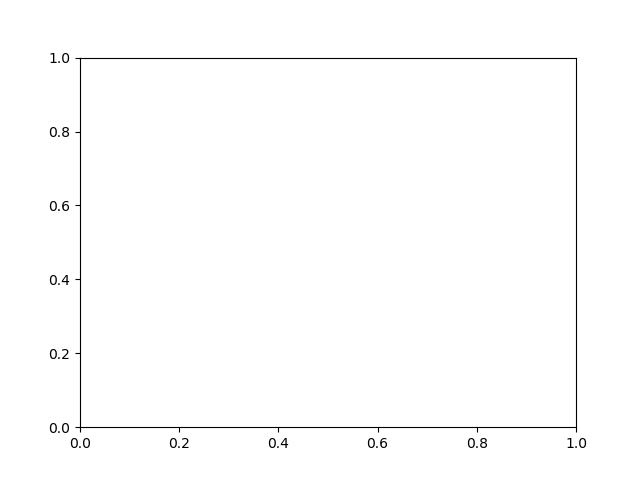

Step : 0, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 1, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 2, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0

uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 18, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 19, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]

Step : 35, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 36, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 37, Signals : 0
Weights : tensor([0., 0.]), mean : tensor

uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 53, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 54, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]

Step : 70, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 71, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 72, Signals : 0
Weights : tensor([0., 0.]), mean : tensor

uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 88, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])
Step : 89, Signals : 0
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]), mean : tensor([0.5000, 0.5000]), exp_error : tensor([1., 1.]), 
uncertainty : tensor([4.9233, 4.9233])
Weights : tensor([0., 0.]

uncertainty : tensor([3.3618, 2.8811])
Weights : tensor([ 0.5912, -0.1070]), mean : tensor([0.6269, 0.4043]), exp_error : tensor([0.0172, 0.2067]), 
uncertainty : tensor([0.8523, 3.3772])
Weights : tensor([0.5522, 0.5950]), mean : tensor([0.4109, 0.6343]), exp_error : tensor([0.0080, 0.0171]), 
uncertainty : tensor([0.8828, 0.8394])

tensor([0.3287, 0.5071])
tensor([0.0000, 0.5134])
tensor([0., 0.])
Step : 103, Signals : 6
Weights : tensor([-0.1073, -0.1141]), mean : tensor([0.4087, 0.6313]), exp_error : tensor([0.2085, 0.3243]), 
uncertainty : tensor([3.3618, 2.8811])
Weights : tensor([ 0.5912, -0.1070]), mean : tensor([0.6269, 0.4043]), exp_error : tensor([0.0172, 0.2067]), 
uncertainty : tensor([0.8523, 3.3772])
Weights : tensor([0.5522, 0.5950]), mean : tensor([0.4109, 0.6343]), exp_error : tensor([0.0080, 0.0171]), 
uncertainty : tensor([0.8828, 0.8394])

tensor([0.2630, 0.4056])
tensor([0.0000, 0.4107])
tensor([0., 0.])
Step : 104, Signals : 6
Weights : tensor([-0.1073, -0.1141])

uncertainty : tensor([0.8523, 3.3772])
Weights : tensor([0.5522, 0.5950]), mean : tensor([0.4109, 0.6343]), exp_error : tensor([0.0080, 0.0171]), 
uncertainty : tensor([0.8828, 0.8394])

tensor([0.0116, 0.0178])
tensor([0.0000, 0.0181])
tensor([0., 0.])
Step : 118, Signals : 6
Weights : tensor([-0.1073, -0.1141]), mean : tensor([0.4087, 0.6313]), exp_error : tensor([0.2085, 0.3243]), 
uncertainty : tensor([3.3618, 2.8811])
Weights : tensor([ 0.5912, -0.1070]), mean : tensor([0.6269, 0.4043]), exp_error : tensor([0.0172, 0.2067]), 
uncertainty : tensor([0.8523, 3.3772])
Weights : tensor([0.5522, 0.5950]), mean : tensor([0.4109, 0.6343]), exp_error : tensor([0.0080, 0.0171]), 
uncertainty : tensor([0.8828, 0.8394])

tensor([0.0093, 0.0143])
tensor([0.0000, 0.0145])
tensor([0., 0.])
Step : 119, Signals : 6
Weights : tensor([-0.1073, -0.1141]), mean : tensor([0.4087, 0.6313]), exp_error : tensor([0.2085, 0.3243]), 
uncertainty : tensor([3.3618, 2.8811])
Weights : tensor([ 0.5912, -0.1070])

uncertainty : tensor([24.2703, 23.8038])
Weights : tensor([ 0.7982, -0.0622]), mean : tensor([0.6263, 0.0019]), exp_error : tensor([0.0150, 0.1863]), 
uncertainty : tensor([ 0.8000, 24.2430])
Weights : tensor([0.7792, 0.8004]), mean : tensor([0.4057, 0.6371]), exp_error : tensor([0.0073, 0.0148]), 
uncertainty : tensor([0.8560, 0.7841])

tensor([0.3300, 0.5070])
tensor([0.0000, 0.5091])
tensor([0., 0.])
Step : 133, Signals : 9
Weights : tensor([-0.0626, -0.0663]), mean : tensor([0.0019, 0.0030]), exp_error : tensor([0.1888, 0.3644]), 
uncertainty : tensor([24.2703, 23.8038])
Weights : tensor([ 0.7982, -0.0622]), mean : tensor([0.6263, 0.0019]), exp_error : tensor([0.0150, 0.1863]), 
uncertainty : tensor([ 0.8000, 24.2430])
Weights : tensor([0.7792, 0.8004]), mean : tensor([0.4057, 0.6371]), exp_error : tensor([0.0073, 0.0148]), 
uncertainty : tensor([0.8560, 0.7841])

tensor([0.2640, 0.4056])
tensor([0.0000, 0.4073])
tensor([0., 0.])
Step : 134, Signals : 9
Weights : tensor([-0.0626, -

tensor([0., 0.])
tensor([0.5109, 0.7921])
Step : 147, Signals : 11
Weights : tensor([-0.0618, -0.0690]), mean : tensor([0.0283, 0.0436]), exp_error : tensor([0.1071, 0.1454]), 
uncertainty : tensor([11.3352, 10.2080])
Weights : tensor([ 0.8460, -0.0609]), mean : tensor([0.6422, 0.0280]), exp_error : tensor([0.0132, 0.1062]), 
uncertainty : tensor([ 0.7370, 11.3695])
Weights : tensor([0.7792, 0.8004]), mean : tensor([0.4057, 0.6371]), exp_error : tensor([0.0073, 0.0148]), 
uncertainty : tensor([0.8560, 0.7841])

tensor([0.6475, 0.0000])
tensor([0., 0.])
tensor([0.4088, 0.6337])
#####In signal : tensor([0., 0., 1.]), 
Step : 148, Signals : 12
Weights : tensor([-0.0618, -0.0690]), mean : tensor([0.0283, 0.0436]), exp_error : tensor([0.1071, 0.1454]), 
uncertainty : tensor([11.3352, 10.2080])
Weights : tensor([ 0.8460, -0.0609]), mean : tensor([0.6422, 0.0280]), exp_error : tensor([0.0132, 0.1062]), 
uncertainty : tensor([ 0.7370, 11.3695])
Weights : tensor([0.7792, 0.8004]), mean : tensor

uncertainty : tensor([0.8163, 0.7424])

tensor([0.0285, 0.0437])
tensor([0.0000, 0.0441])
tensor([0., 0.])
Step : 162, Signals : 12
Weights : tensor([-0.0618, -0.0690]), mean : tensor([0.0283, 0.0436]), exp_error : tensor([0.1071, 0.1454]), 
uncertainty : tensor([11.3352, 10.2080])
Weights : tensor([ 0.8460, -0.0609]), mean : tensor([0.6422, 0.0280]), exp_error : tensor([0.0132, 0.1062]), 
uncertainty : tensor([ 0.7370, 11.3695])
Weights : tensor([0.8228, 0.8466]), mean : tensor([0.4088, 0.6337]), exp_error : tensor([0.0067, 0.0130]), 
uncertainty : tensor([0.8163, 0.7424])

tensor([0.0228, 0.0350])
tensor([0.0000, 0.0353])
tensor([0., 0.])
Step : 163, Signals : 12
Weights : tensor([-0.0618, -0.0690]), mean : tensor([0.0283, 0.0436]), exp_error : tensor([0.1071, 0.1454]), 
uncertainty : tensor([11.3352, 10.2080])
Weights : tensor([ 0.8460, -0.0609]), mean : tensor([0.6422, 0.0280]), exp_error : tensor([0.0132, 0.1062]), 
uncertainty : tensor([ 0.7370, 11.3695])
Weights : tensor([0.8228

uncertainty : tensor([0.8163, 0.7424])

Charges : tensor([0.6445, 0.0019])
Likelihood of sample : tensor([0.9998, 0.9968])
tensor([0.8128, 0.0000])
tensor([0., 0.])
tensor([0.5045, 0.7812])
Step : 177, Signals : 14
Weights : tensor([-0.0434, -0.0495]), mean : tensor([0.0020, 0.0030]), exp_error : tensor([0.0723, 0.0906]), 
uncertainty : tensor([22.0930, 20.6917])
Weights : tensor([ 0.9018, -0.0432]), mean : tensor([0.6445, 0.0019]), exp_error : tensor([0.0117, 0.0718]), 
uncertainty : tensor([ 0.6943, 22.1210])
Weights : tensor([0.8228, 0.8466]), mean : tensor([0.4088, 0.6337]), exp_error : tensor([0.0067, 0.0130]), 
uncertainty : tensor([0.8163, 0.7424])

tensor([0.6502, 0.0000])
tensor([0., 0.])
tensor([0.4036, 0.6250])
#####In signal : tensor([0., 0., 1.]), 
Step : 178, Signals : 15
Weights : tensor([-0.0434, -0.0495]), mean : tensor([0.0020, 0.0030]), exp_error : tensor([0.0723, 0.0906]), 
uncertainty : tensor([22.0930, 20.6917])
Weights : tensor([ 0.9018, -0.0432]), mean : tensor(

tensor([0.5169, 0.8127])
tensor([0.0000, 0.8092])
tensor([0., 0.])
Step : 191, Signals : 18
Weights : tensor([-0.0789, -0.0964]), mean : tensor([0.1091, 0.1677]), exp_error : tensor([0.0559, 0.0715]), 
uncertainty : tensor([5.1673, 4.2731])
Weights : tensor([ 0.8250, -0.0796]), mean : tensor([0.6441, 0.1075]), exp_error : tensor([0.0104, 0.0556]), 
uncertainty : tensor([0.6588, 5.2016])
Weights : tensor([0.7753, 0.8244]), mean : tensor([0.4146, 0.6348]), exp_error : tensor([0.0057, 0.0103]), 
uncertainty : tensor([0.7471, 0.6653])

tensor([0.4135, 0.6501])
tensor([0.0000, 0.6474])
tensor([0., 0.])
Step : 192, Signals : 18
Weights : tensor([-0.0789, -0.0964]), mean : tensor([0.1091, 0.1677]), exp_error : tensor([0.0559, 0.0715]), 
uncertainty : tensor([5.1673, 4.2731])
Weights : tensor([ 0.8250, -0.0796]), mean : tensor([0.6441, 0.1075]), exp_error : tensor([0.0104, 0.0556]), 
uncertainty : tensor([0.6588, 5.2016])
Weights : tensor([0.7753, 0.8244]), mean : tensor([0.4146, 0.6348]), exp

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

epochs = 200

x_fire = np.array(random.sample(range(1,epochs//6), (epochs//6) // 5))*6

#x_fire = np.array(list(range(0,epochs,6)))
y_fire = (x_fire + 2)
z_fire = (y_fire + 2)

#print(x_fire)
#x_fire = []
signals = 0
for e in range(epochs):
    in_stream = torch.tensor([e in x_fire, e in y_fire, e in z_fire], dtype=torch.float)
    
    
    if 1 in in_stream:
        print("#####In signal : {}, ".format(in_stream.data))
        signals += 1
    
    print("Step : {}, Signals : {}".format(e, signals))
    #print()    
    #print()
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    
    s = model(in_stream)
    #draw_spikes(s,[2,1], ax)
    #fig.canvas.draw()
    #time.sleep(0.1)

In [4]:
def get_uncertainty( c):
       
        v = (torch.log10(c)/torch.log10(torch.tensor(0.9).float())) 
        return v**1/2
    
print(get_uncertainty(torch.tensor(0.1).float()))

tensor(10.9272)


In [5]:
print(np.array(list(range(0,epochs,6))))

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198]


In [6]:
print(x_fire)

[174  96 144 186  90 126]
